# Урок 4. СРАВНЕНИЕ СРЕДНИХ ЗНАЧЕНИЙ (T-ТЕСТ)

Представьте, что вы работаете аналитиком в очень крупной компании по доставке пиццы над приложением для курьеров (да, обычно в таких компаниях есть приложение для курьеров и отдельно приложение для потребителей).

У вас есть несколько ресторанов в разных частях города и целый штат курьеров. Но есть одна проблема — к вечеру скорость доставки падает из-за того, что курьеры уходят домой после рабочего дня, а количество заказов лишь растет. Это приводит к тому, что в момент пересмены наша доставка очень сильно проседает в эффективности. 

Наши data scientist-ы придумали новый алгоритм, который позволяет курьерам запланировать свои последние заказы перед окончанием рабочего дня так, чтобы их маршрут доставки совпадал с маршрутом до дома. То есть, чтобы курьеры доставляли последние свои заказы за день как бы "по пути" домой. 

Вы вместе с командой решили раскатить A/B тест на две равные группы курьеров. Часть курьеров использует старый алгоритм без опции "по пути", другие видят в своем приложении эту опцию и могут ее выбрать. Ваша задача – проанализировать данные эксперимента и помочь бизнесу принять решение о раскатке новой фичи на всех курьеров.

Описание данных

· order_id - id заказа  
· delivery_time - время доставки в минутах  
· district - район доставки  
· experiment_group - экспериментальная группа

In [1]:
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

experiment = pd.read_csv('experiment_lesson_4.csv')

In [2]:
experiment.head()

,order_id,delivery_time,district,experiment_group
0,3159,44.0,Purlieus,control
1,10426,51.0,Purlieus,control
2,9155,46.0,Purlieus,control
3,10699,34.0,Purlieus,control
4,10061,43.0,Purlieus,control


In [3]:
experiment.dtypes

order_id              int64
delivery_time       float64
district             object
experiment_group     object
dtype: object

### 1

Для начала давайте сформулируем гипотезы для проверки. Выберите статистические гипотезы, которые мы сможем проверить в этом эксперименте:

· Нулевая гипотеза (H0): Изменение алгоритма не влияет на скорость доставки  
__· Альтернативная гипотеза (H1): Разница между средним временем доставки в тестовой и контрольной группе есть__   
· Альтернативная гипотеза (H1): Изменение алгоритма влияет на скорость доставки  
· Нулевая гипотеза (H0): Разница между средним временем доставки в тестовой и контрольной группе есть  
__· Нулевая гипотеза (H0): Разницы между средним временем доставки в тестовой и контрольной группе нет__    
· Альтернативная гипотеза (H1): Разницы между средним временем доставки в тестовой и контрольной нет

### 2

Построейте графики распределения экспериментальных групп:

district
Central     AxesSubplot(0.125,0.125;0.775x0.755)
Purlieus    AxesSubplot(0.125,0.125;0.775x0.755)
Suburb      AxesSubplot(0.125,0.125;0.775x0.755)
Name: delivery_time, dtype: object

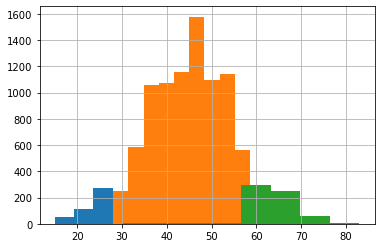

In [8]:
experiment.query('experiment_group == "control"').groupby('district').delivery_time.hist()

district
Central     AxesSubplot(0.125,0.125;0.775x0.755)
Purlieus    AxesSubplot(0.125,0.125;0.775x0.755)
Suburb      AxesSubplot(0.125,0.125;0.775x0.755)
Name: delivery_time, dtype: object

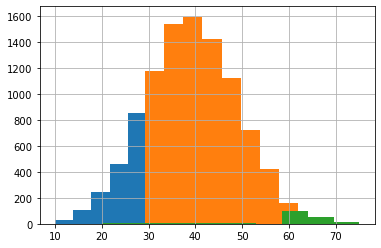

In [9]:
experiment.query('experiment_group == "test"').groupby('district').delivery_time.hist()

### 3

Посчитайте количество наблюдений в тестовой и контрольной группе. На сколько по модулю отличается количество наблюдений в тесте и контроле?

In [13]:
abs(experiment.query('experiment_group == "control"').shape[0] - experiment.query('experiment_group == "test"').shape[0])

12

In [20]:
cnt = experiment.groupby('experiment_group').order_id.count()
print(cnt)
print(cnt[1] - cnt[0])

experiment_group
control    10092
test       10104
Name: order_id, dtype: int64
12


### 4

Теперь давайте изучим наши распределения. Проверим выполнение условий на нормальность и посчитаем стандартное отклонение в тесте и в контроле.

Обязательно сделайте семплирование перед применением критерия при проверке на нормальность (и для теста, и для контроля), так как на больших выборках вы можете получать неверные результаты.

Для того, чтобы проверить нормальность распределения, я использую __SHAPIRO-WILK TEST__. Этот тест показывает, что значения в тестовой группе распределены 
__НОРМАЛЬНО__. В контрольной группе распределение является __НОРМАЛЬНЫМ__. Стандартное отклонение времени доставки в тесте равно (округлите до сотых) __9.88__. Стандартное отклонение времени доставки в контроле равно (округлите до сотых) 
__9.99__.

In [26]:
stats.shapiro(experiment.query('experiment_group == "control"').delivery_time.sample(1000, random_state=17))

ShapiroResult(statistic=0.9974725842475891, pvalue=0.12411931157112122)

In [27]:
stats.shapiro(experiment.query('experiment_group == "test"').delivery_time.sample(1000, random_state=17))

ShapiroResult(statistic=0.9975475668907166, pvalue=0.14005419611930847)

In [28]:
round((experiment.query('experiment_group == "test"').delivery_time.std()), 2)

9.88

In [29]:
round((experiment.query('experiment_group == "control"').delivery_time.std()), 2)

9.99

__Зачем нам нужен был метод .sample()?__

Чувствительность любого теста зависит от размера выборки. Это касается и теста Шапиро-Уилка - на больших выборках он детектирует даже самые незначительные отклонения от нормальности. Поэтому мы берём случайные 1000 значений из выборки, чтобы обойти этот недостаток.

Есть шанс, что случайные 1000 значений всё же сформируют ненормальное распределение, поэтому рекомендуем использовать аргумент random_state=17 для стабильности и воспроизводимости результатов.

__Какова нулевая гипотеза теста Шапиро-Уилка?__

Что распределение нормальное. 

### 5

Пришло время сравнить средние в тесте и контроле. Внимание: здесь уже не нужно пользоваться методом sample() — он нам нужен был только для теста Шапиро-Уилка, остальные тесты надо проводить на полных данных.

Для сравнения средних в данных экспериментальных группах я использую __STUDENT'S T-TEST__. Статистика в тесте равна (округлите до целого) 
__-43__, p-value __<= 0.05__.

In [31]:
stats.ttest_ind(experiment.query('experiment_group == "test"').delivery_time, \
                experiment.query('experiment_group == "control"').delivery_time)

Ttest_indResult(statistic=-43.03582663183714, pvalue=0.0)

### 6

На сколько процентов изменилось среднее время доставки в тестовой группе по сравнению с контрольной (округлите до сотых)? 

In [32]:
test_mean = experiment.query('experiment_group == "test"').delivery_time.mean()
control_mean = experiment.query('experiment_group == "control"').delivery_time.mean()

In [43]:
perc = (test_mean - control_mean) / control_mean * 100
round(perc, 2)

-13.35

### 7

Что в итоге? Катим? 

· Да, раскатываем на всех, новый алгоритм напрямую влияет на скорость доставки.  
· Да, раскатываем новый алгоритм на всех, так как среднее время доставки статистически значимо изменилось. Среднее время доставки в тесте больше, чем в контроле.  
· Не катим, так как среднее время доставки статистически значимо не изменилось.  
__· Да, раскатываем новый алгоритм на всех, так как среднее время доставки статистически значимо изменилось. Среднее время доставки в тесте меньше, чем в контроле.__